In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import meteostat
import datetime as dt

## Exploratory Data Analysis & Data Preprocessing

I will begin the project with a Exploratory Data Analysis performing some simple **statistics** and **visualizations** to observe the nature of the data and gain insights about it.

In [2]:
data = pd.read_excel("VBCData.xlsx")
data

,Unnamed: 0,Unnamed: 1,Date,Day,Breakfast,Lunch,Dinner,Total,Weather,Notes,Unnamed: 10,Avg Spend
0,NaN,NaN,2023-12-31,Sunday,88,105,0,193,Overcast,NaN,3649.27,18.908135
1,NaN,NaN,2023-12-30,Saturday,56,149,28,233,PM Rain,NaN,4643.05,19.927253
2,NaN,NaN,2023-12-29,Friday,30,154,17,201,PM Rain,NaN,3715.30,18.484080
3,NaN,NaN,2023-12-28,Thursday,26,154,21,201,PM Rain,NaN,3677.01,18.293582
4,NaN,NaN,2023-12-27,Wednesday,43,138,13,194,PM Rain,NaN,3239.03,16.696031
...,...,...,...,...,...,...,...,...,...,...,...,...
9074,NaN,NaN,2000-01-05,Wednesday,8,110,20,138,NaN,NaN,1320.27,9.567174
9075,NaN,NaN,2000-01-04,Tuesday,5,92,0,97,NaN,NaN,1077.91,11.112474
9076,NaN,NaN,2000-01-03,Monday,3,79,0,82,Part Sunny,Warm,840.04,10.244390
9077,NaN,NaN,2000-01-02,Sunday,55,161,29,245,NaN,NaN,2259.14,9.220980


The following actions were taken to preprocess the data before we begin the analysis:
* Dropped unnecessary columns.
* Named column 'Revenue'.
* Checked data types.

In [3]:
data = data.drop(columns=["Unnamed: 0", "Unnamed: 1"]).rename(columns={"Unnamed: 10": "Revenue"})
data.dtypes

Date          datetime64[ns]
Day                   object
Breakfast              int64
Lunch                  int64
Dinner                 int64
Total                  int64
Weather               object
Notes                 object
Revenue              float64
Avg Spend            float64
dtype: object

All columns seem to have the proper data type. Therefore, no formatting is required here. The preprocessed dataset to be used will be the following:

In [4]:
data.describe()

,Date,Breakfast,Lunch,Dinner,Total,Revenue,Avg Spend
count,9079,9079.000000,9079.000000,9079.000000,9079.000000,9070.000000,8915.000000
mean,2012-05-15 19:43:12.840621312,31.088115,133.909131,37.508316,202.517678,2985.114173,14.730858
min,2000-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2006-03-19 12:00:00,8.000000,87.000000,0.000000,114.000000,1561.997500,12.609058
50%,2012-06-05 00:00:00,15.000000,119.000000,32.000000,172.000000,2508.100000,14.318143
75%,2018-08-22 12:00:00,40.000000,162.000000,59.000000,260.500000,3929.772500,16.126611
max,2023-12-31 00:00:00,222.000000,585.000000,209.000000,821.000000,14833.490000,568.090000
std,NaN,36.934156,72.448446,37.483778,123.561512,1961.484184,6.894470


From this summary table we can observe there are **missing values.** The dataset contains records from 9,079 days (i.e. 9078/366 = 24.8 years). Interestingly, we only have 'Avg Spend' (average expenditure) data from 8915 days. That means 164 values are missing and should be handled appropriately. Similarly, we only have 'Revenue' data from 9070 days, meaning 9 values are missing. Missing values should either be dropped or filled in with interpolated data to prevent the impact of null values on predictions. Given the time series nature of the problem, dropping values would discontinue the series and this could cause problems. Therefore, we will fill in the missing values. There are multiple methods to do so, including the *mean imputation*, *median imputation*, *Last Observation Carried Forward (LOCF)*, *Next Observation Carried Backward (NOCB)*, *linear interpolation* or the *spline imputation* ([GeeksForGeeks](https://www.geeksforgeeks.org/how-to-deal-with-missing-values-in-a-timeseries-in-python/), accessed March 2024). Given that there are only a small number of missing values, we can perform **spline interpolation** on them, which is the most computationally expensive method but also the most accurate for capturing complex trends and subtle changes in time series data. It estimates missing values by fitting a flexible, curved line through the data points.

In [5]:
data["Total"] = data["Total"].replace(0, np.nan).interpolate(option='spline')

By doing this, I am **dealing with the days where the restaurant was closed** (i.e., the count of meals served was 0), so that it does not impact predictions.

### Demand Evolution

The **total demand per quarter** will now be plotted to observe how meal servings have evolved over the years.

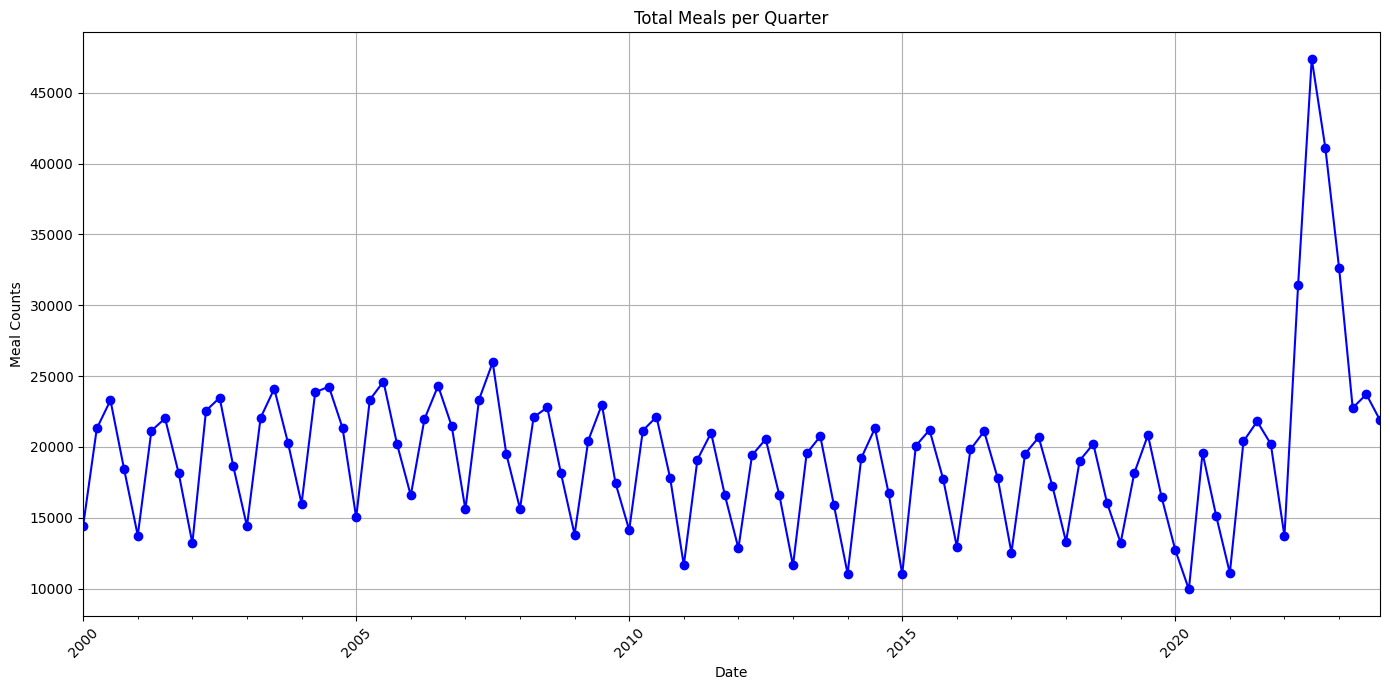

In [6]:
# Data Resampling (to obtain quarterly observations)
data.set_index('Date', inplace=True)
quarterly_data = data['Total'].resample('QE').sum()

# Plotting
plt.figure(figsize=(14, 7))
quarterly_data.plot(marker='o', linestyle='-', color='b')
plt.title('Total Meals per Quarter')
plt.xlabel('Date')
plt.ylabel('Meal Counts')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

The data seems to have a clear **yearly seasonality**. Throughout the entire series, we can see that the **first quarter** of the year (i.e. the months of January, February, March) produces the **lowest earnings** in the year, with the second (April, May, June) and third (July, August, September) quarters (the **warmer months**) being the **most profitable** ones. 

### Outliers and Data Duplicates

An **outlier during 2022** can be easily observed. This year, revenue almost reached 3 times the value of other years' revenue. This could be due to either the effect of external factors or issues in the data collection process. To check for this, we will first check for **duplicated records** in the data:

In [7]:
duplicate_dates = data[data.index.duplicated()]
duplicate_dates

,Day,Breakfast,Lunch,Dinner,Total,Weather,Notes,Revenue,Avg Spend
Date,,,,,,,,,
2023-04-25,Tuesday,21,84,0,105.0,Cold As F,NaN,2127.22,20.259238
2023-03-31,Friday,25,112,59,196.0,NaN,NaN,3760.30,19.185204
2023-03-30,Thursday,36,99,25,160.0,NaN,NaN,3238.70,20.241875
2023-03-29,Wednesday,8,107,25,140.0,NaN,NaN,2470.46,17.646143
2023-03-28,Tuesday,12,87,0,99.0,NaN,NaN,1858.06,18.768283
...,...,...,...,...,...,...,...,...,...
2022-05-27,Friday,21,133,95,249.0,NaN,NaN,4586.17,18.418353
2022-05-26,Thursday,24,154,40,218.0,NaN,NaN,4139.37,18.987936
2022-05-25,Wednesday,17,140,52,209.0,Beautiful,NaN,3877.41,18.552201


As suspected, there are **314 duplicated values** in the dataset. We will then proceed to remove them and replot the to quarterly revenues:

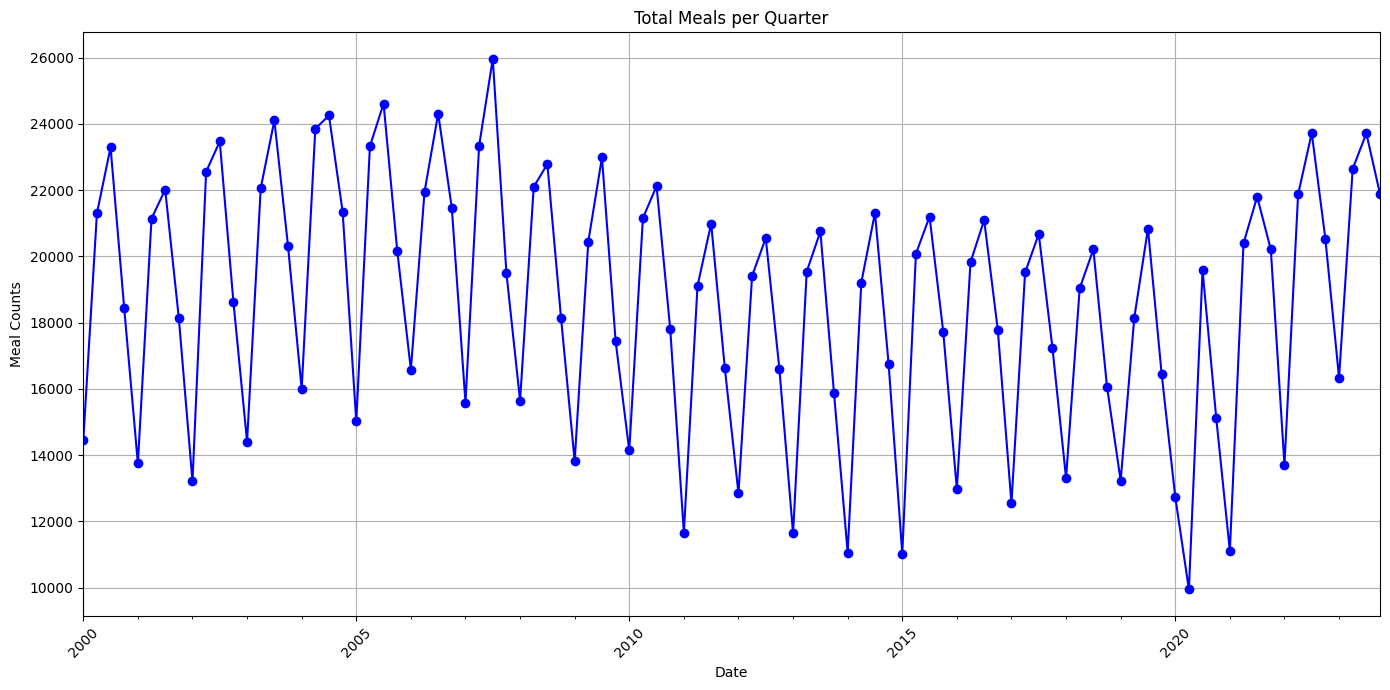

In [8]:
data = (data.reset_index().drop_duplicates(subset='Date', keep='last').set_index('Date').sort_index())
quarterly_meals = data['Total'].resample('QE').sum()

plt.figure(figsize=(14, 7))
quarterly_meals.plot(marker='o', linestyle='-', color='b')
plt.title('Total Meals per Quarter')
plt.xlabel('Date')
plt.ylabel('Meal Counts')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

This seems much more reasonable. With a clean dataset now, we can now proceed to perform the analysis and forecast.

## Stationarity

In [9]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff

### Classic Additive Decomposition

In [10]:
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

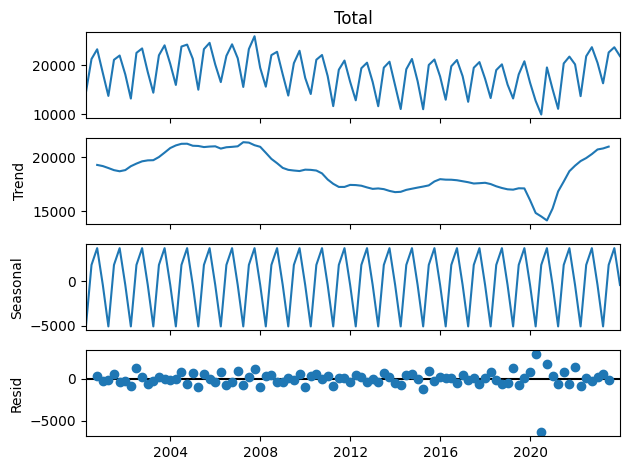

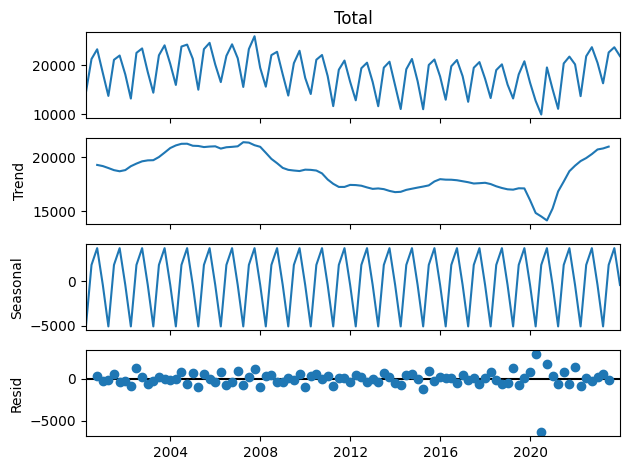

In [11]:
decomp_quarterly = statsmodels.tsa.seasonal.seasonal_decompose(quarterly_meals)
decomp_quarterly.plot()

### Augmented Dickey-Fuller Test

*  **Null hypothesis**: Non-Stationarity exists in the series.
*  **Alternative Hypothesis**: Stationarity exists in the series.

In [12]:
adfuller(quarterly_meals)

(-1.5826234123882856,
 0.49231620040665813,
 11,
 84,
 {'1%': -3.510711795769895,
  '5%': -2.8966159448223734,
  '10%': -2.5854823866213152},
 1475.1346689627142)

1. -1.5826234123882856 --> Critical value of the data.
2. 0.49231620040665813 --> Probability that null hypothesis will not be rejected(p-value)
3. 11 --> Number of lags used in regression to determine t-statistic. 
4. 84 --> Number of observations used in the analysis.
5. {'1%': -3.510711795769895, '5%': -2.8966159448223734, '10%': -2.5854823866213152} --> T values corresponding to adfuller test.
Since critical values -1.58 > -3.5, -2.8, -2.5 (t-values at 1%, 5%, and 10% confidence intervals), the null hypothesis cannot be rejected. So there is non-stationarity in the data. Also p-value of 0.49 > 0.05(if we take a 5% significance level or 95% confidence interval), the null hypothesis cannot be rejected. Hence the **data is nonstationary** (that means it has a relation with time).

## Transformations

Since it is nonstationary, we can apply a **differencing transformation** to the data:

In [13]:
diff_quarterly1 = diff(quarterly_meals, k_diff=1, k_seasonal_diff=1, seasonal_periods=4)
adfuller(diff_quarterly1)

(-3.7530530338166477,
 0.0034258692145842785,
 10,
 80,
 {'1%': -3.5148692050781247, '5%': -2.8984085156250003, '10%': -2.58643890625},
 1390.005167608742)

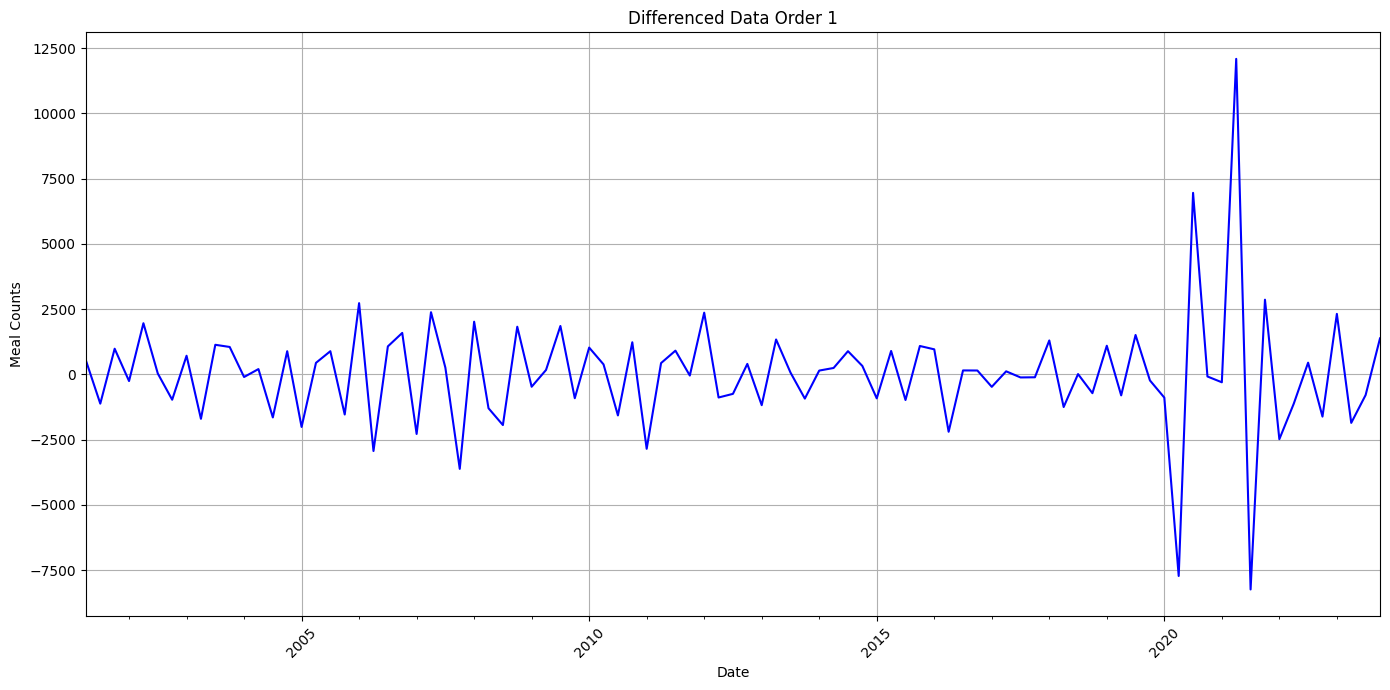

In [14]:
plt.figure(figsize=(14, 7))
diff_quarterly1.plot(linestyle='-', color='b')
plt.title('Differenced Data Order 1')
plt.xlabel('Date')
plt.ylabel('Meal Counts')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

## Auto-Regressive Integrated Moving Average (ARIMA)

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

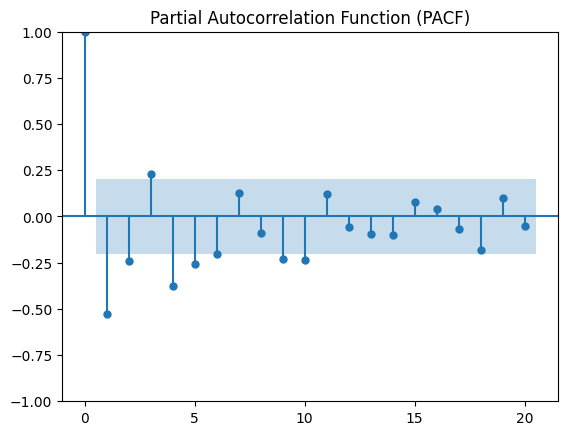

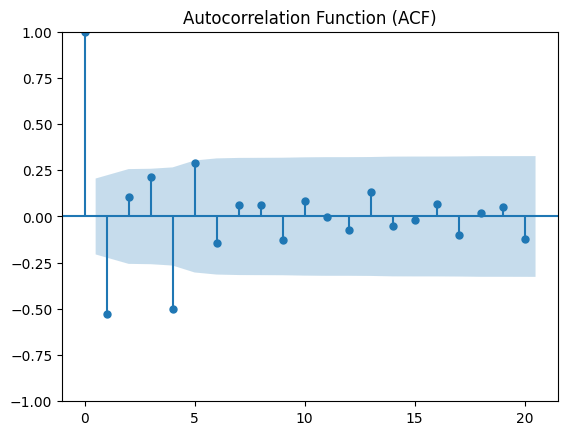

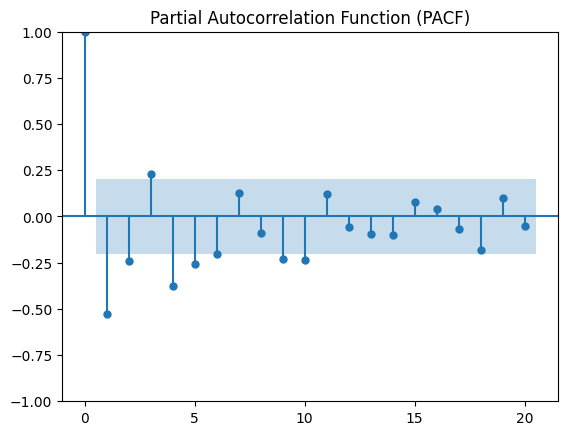

In [16]:
plot_acf(diff_quarterly1, title='Autocorrelation Function (ACF)')
plot_pacf(diff_quarterly1, title='Partial Autocorrelation Function (PACF)')

I will use the `auto_arima` function from the `pmdarima` package to **automatically estimate the proper order** of the ARIMA model we will fit afterwards.

In [17]:
#arima_order = auto_arima(diff_quarterly1, seasonal=True, trace=True, stationary=True)

The `auto_arima` function returned very high orders, so I will test different orders manually instead.

### Model without intervention
*  **ARMA (2,1,2) x SARMA (1,1,1)[4] --> 1551.71**
*  ARMA (2,1,1) x SARMA (1,1,1)[4] --> 1552.54
*  ARMA (2,1,0) x SARMA (1,1,1)[4] --> 1573.81
*  ARMA (1,1,2) x SARMA (1,1,1)[4] --> 1567.62
*  ARMA (0,1,2) x SARMA (1,1,1)[4] --> 1554.08
*  ARMA (2,1,2) x SARMA (0,1,1)[4] --> 1565.92
*  ARMA (2,0,2) x SARMA (0,1,1)[4] --> 1563.52
*  ARMA (0,0,5) x SARMA (0,0,0)[4] --> 1597.16

#### Model fit

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Params
p = 2
d = 1
q = 2

# Seasonal params
P = 1
D = 1 # stable seasonal pattern
Q = 1
s = 4 # quarterly data

sarimax = SARIMAX(diff_quarterly1,
                  order=(p,d,q),
                  seasonal_order=(P,D,Q,s))

results = sarimax.fit(maxiter=1000)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.84902D+00    |proj g|=  1.44724D-01

At iterate    5    f=  8.78383D+00    |proj g|=  7.14758D-03

At iterate   10    f=  8.78322D+00    |proj g|=  1.33650D-03

At iterate   15    f=  8.78287D+00    |proj g|=  1.16053D-03

At iterate   20    f=  8.78286D+00    |proj g|=  3.38762D-04

At iterate   25    f=  8.78225D+00    |proj g|=  6.70825D-03

At iterate   30    f=  8.67416D+00    |proj g|=  3.92718D-01

At iterate   35    f=  8.50697D+00    |proj g|=  3.38210D-02

At iterate   40    f=  8.48230D+00    |proj g|=  7.05250D-04


 This problem is unconstrained.



At iterate   45    f=  8.45254D+00    |proj g|=  3.40408D-02

At iterate   50    f=  8.44897D+00    |proj g|=  1.49686D-05

At iterate   55    f=  8.44897D+00    |proj g|=  5.67305D-04

At iterate   60    f=  8.44896D+00    |proj g|=  6.32362D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     61     93      1     0     0   5.784D-05   8.449D+00
  F =   8.4489636537938253     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [19]:
results.aic

1551.7113849904763

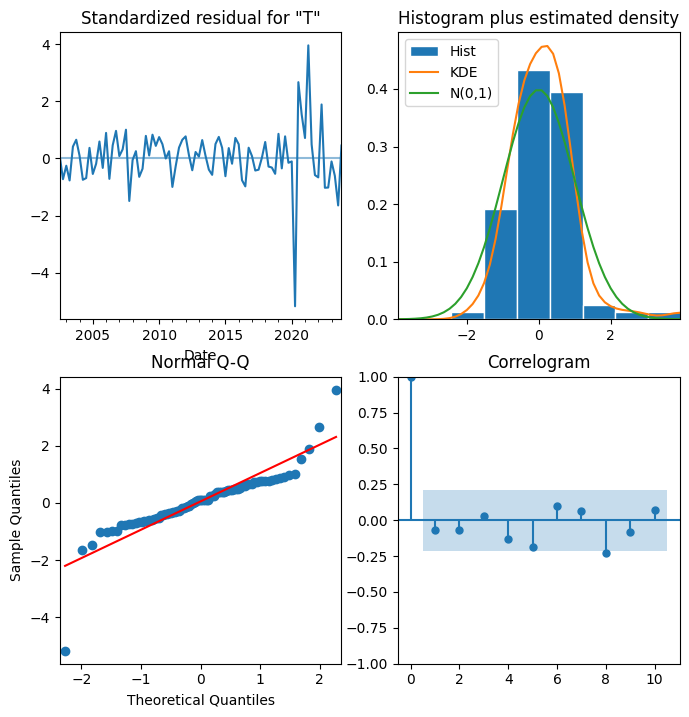

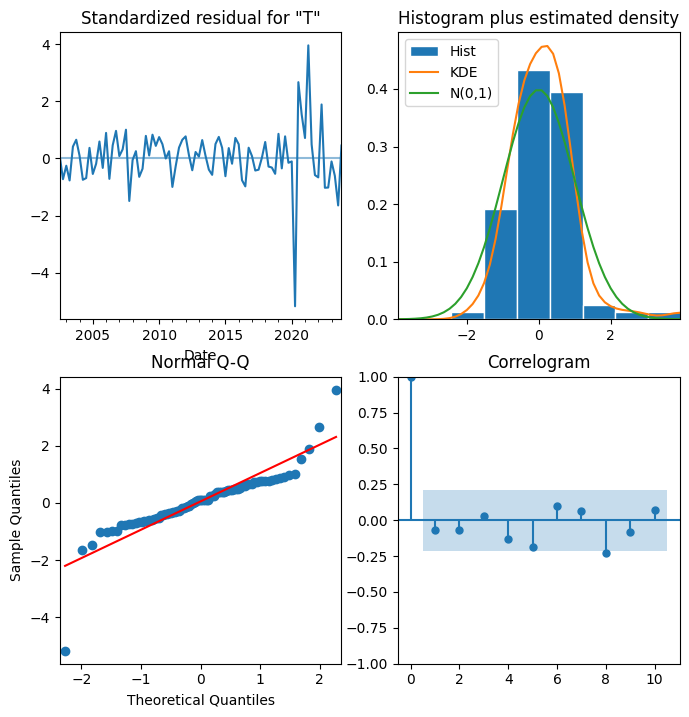

In [20]:
results.plot_diagnostics(figsize=(8, 8.2))

#### Appendix 4.1.2: Evaluation

In [21]:
# Train/validation split
train = diff_quarterly1[dt.datetime(2001,6,30,0,0):dt.datetime(2020,12,31,0,0)]
val = quarterly_meals.iloc[-12:]

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# SARIMAX model
model = SARIMAX(train, order=(0,1,2), seasonal_order=(1,1,1,4))
results = model.fit(maxiter=1000)
forecast = results.get_forecast(steps=12)
forecast_diff = forecast.predicted_mean

# Reverse the differencing to get the forecast on the original scale
last_value = quarterly_meals.iloc[-1]  # The last value of the original non-differenced data
val_arima = last_value + forecast_diff.cumsum()

# Evaluation (with train/val dataset)
mae = mean_absolute_error(val, val_arima)
print('MAE:', mae)
rmse = np.sqrt(mean_squared_error(val, val_arima))
print('RMSE:', rmse)
mape = mean_absolute_percentage_error(val, val_arima)
print('MAPE:', mape)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.86329D+00    |proj g|=  2.81365D-01

At iterate    5    f=  8.71901D+00    |proj g|=  7.85570D-03

At iterate   10    f=  8.71735D+00    |proj g|=  1.97061D-04

At iterate   15    f=  8.71664D+00    |proj g|=  2.63318D-03

At iterate   20    f=  8.47744D+00    |proj g|=  5.15867D-03

At iterate   25    f=  8.45212D+00    |proj g|=  2.08229D-03
  ys=-4.573E-05  -gs= 7.869E-04 BFGS update SKIPPED

At iterate   30    f=  8.44277D+00    |proj g|=  2.55415D-03

At iterate   35    f=  8.18048D+00    |proj g|=  1.01947D-02

At iterate   40    f=  8.17810D+00    |proj g|=  1.17391D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of ac

 This problem is unconstrained.


### Model with intervention
*  ARMA (2,1,2) x SARMA (1,1,1)[4] --> 1583.86
*  ARMA (2,1,1) x SARMA (1,1,1)[4] --> 1550.94
*  ARMA (2,1,0) x SARMA (1,1,1)[4] --> 1596.20
*  ARMA (1,1,2) x SARMA (1,1,1)[4] --> 1543.98
*  **ARMA (0,1,2) x SARMA (1,1,1)[4] --> 1543.20**
*  ARMA (2,1,2) x SARMA (0,1,1)[4] --> 1567.82
*  ARMA (2,0,2) x SARMA (0,1,1)[4] --> 1577.51
*  ARMA (0,0,5) x SARMA (0,0,0)[4] --> 1594.33

In [23]:
# Intervention (years 2020 & 2021)
intervention = [1 if '2020-01-01' <= str(date) <= '2022-12-31' else 0 for date in diff_quarterly1.index]

# Params
p = 0
d = 1
q = 2

# Seasonal params
P = 1
D = 1 # stable seasonal pattern
Q = 1
s = 4 # quarterly data

sarimax_intervention = SARIMAX(diff_quarterly1,
                  order=(p,d,q),
                  seasonal_order=(P,D,Q,s),
                  exog=intervention)

results_intervention = sarimax_intervention.fit(maxiter=1000)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.20801D+00    |proj g|=  4.65458D-02

At iterate    5    f=  9.20012D+00    |proj g|=  1.29028D-04

At iterate   10    f=  9.19997D+00    |proj g|=  2.74862D-03

At iterate   15    f=  9.17988D+00    |proj g|=  2.56473D-02

At iterate   20    f=  8.85926D+00    |proj g|=  1.57082D-01

At iterate   25    f=  8.85762D+00    |proj g|=  6.84096D-02

At iterate   30    f=  8.72112D+00    |proj g|=  4.18608D-02

At iterate   35    f=  8.71834D+00    |proj g|=  3.35179D-04

At iterate   40    f=  8.68076D+00    |proj g|=  1.00205D-01

At iterate   45    f=  8.64929D+00    |proj g|=  3.46637D-03

At iterate   50    f=  8.64918D+00    |proj g|=  3.90042D-04

At iterate   55    f=  8.64904D+00    |proj g|=  7.82410D-03

At iterate   60    f=  8.64684D+00    |proj g|=  2.92970D-02

At iterate   65    f=  8.6

In [24]:
results_intervention.aic

1543.2010586163153

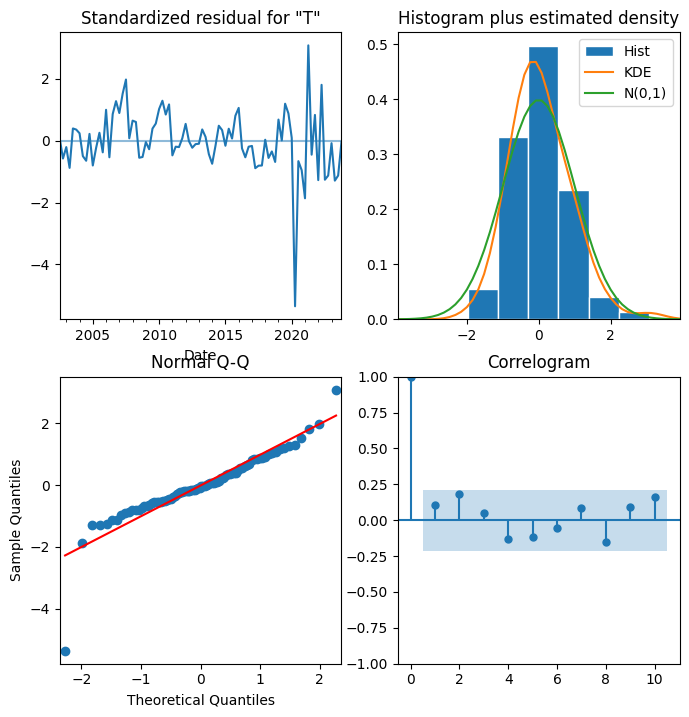

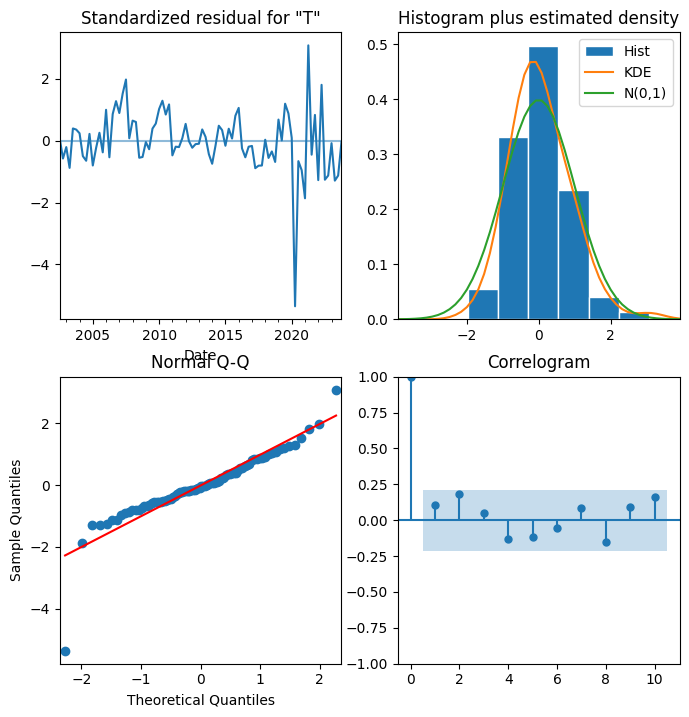

In [25]:
results_intervention.plot_diagnostics(figsize=(8, 8.2))

*  **Standardized Residuals Plot**: The top-left plot shows the standardized residuals over time. Ideally, you want to see no pattern, suggesting the residuals are white noise. If there's a clear pattern, especially systematic or periodic variations, it suggests the model is not capturing some aspect of the data. Here, there doesn't seem to be any obvious pattern, which is good.
*  **Histogram plus KDE (Kernel Density Estimate) Plot**: The top-right plot compares the distribution of the standardized residuals to a normal distribution. The blue histogram represents the frequency of standardized residuals, the orange line is the KDE that estimates the density of the residuals, and the green line represents a normal distribution. Ideally, the KDE should follow closely with the normal distribution line. There's a slight deviation on the tails, suggesting the presence of outliers or heavy tails in the distribution of residuals.
*  **Normal Q-Q Plot**: The bottom-left plot is a Quantile-Quantile plot. It compares the quantiles of the standardized residuals with the quantiles of a normal distribution. If the points lie on the red line, it indicates that the residuals are normally distributed. In this plot, most of the data points fall along the line, but there are deviations on both ends, indicating that the residuals may not be perfectly normally distributed.
*  **Correlogram (ACF Plot)**: The bottom-right plot shows the autocorrelation function (ACF) of the residuals. For a well-fitting model, you would expect that there would be no significant autocorrelation in the residuals. This plot typically has blue lines that represent confidence intervals – if the bars are within this area, it is assumed that there are no significant autocorrelations. The correlogram here looks good, as all the autocorrelations are within the confidence band, suggesting that there is no significant autocorrelation.

#### Forecast (next 10 periods)

In [26]:
# SARIMAX model for predicting next 10 periods
model = SARIMAX(diff_quarterly1, order=(0,1,2), seasonal_order=(1,1,1,4), exog=intervention)
results = model.fit(maxiter=1000)
forecast = results.get_forecast(steps=10, exog=[0]*10)
forecast_diff = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Reverse the differencing to get the forecast on the original scale
last_value = quarterly_meals.iloc[-1]  # The last value of the original non-differenced data
forecast_integrated = last_value + forecast_diff.cumsum()

# Calculate the cumulative sum of the forecasted lower and upper bounds.
integrated_lower_bound = forecast_integrated - (forecast_diff.iloc[0] - forecast_conf_int.iloc[:, 0].cumsum())
integrated_upper_bound = forecast_integrated + (forecast_conf_int.iloc[:, 1].cumsum() - forecast_diff.iloc[0])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.20801D+00    |proj g|=  4.65458D-02

At iterate    5    f=  9.20012D+00    |proj g|=  1.29028D-04

At iterate   10    f=  9.19997D+00    |proj g|=  2.74862D-03

At iterate   15    f=  9.17988D+00    |proj g|=  2.56473D-02

At iterate   20    f=  8.85926D+00    |proj g|=  1.57082D-01

At iterate   25    f=  8.85762D+00    |proj g|=  6.84096D-02

At iterate   30    f=  8.72112D+00    |proj g|=  4.18608D-02

At iterate   35    f=  8.71834D+00    |proj g|=  3.35179D-04

At iterate   40    f=  8.68076D+00    |proj g|=  1.00205D-01

At iterate   45    f=  8.64929D+00    |proj g|=  3.46637D-03

At iterate   50    f=  8.64918D+00    |proj g|=  3.90042D-04

At iterate   55    f=  8.64904D+00    |proj g|=  7.82410D-03

At iterate   60    f=  8.64684D+00    |proj g|=  2.92970D-02

At iterate   65    f=  8.6

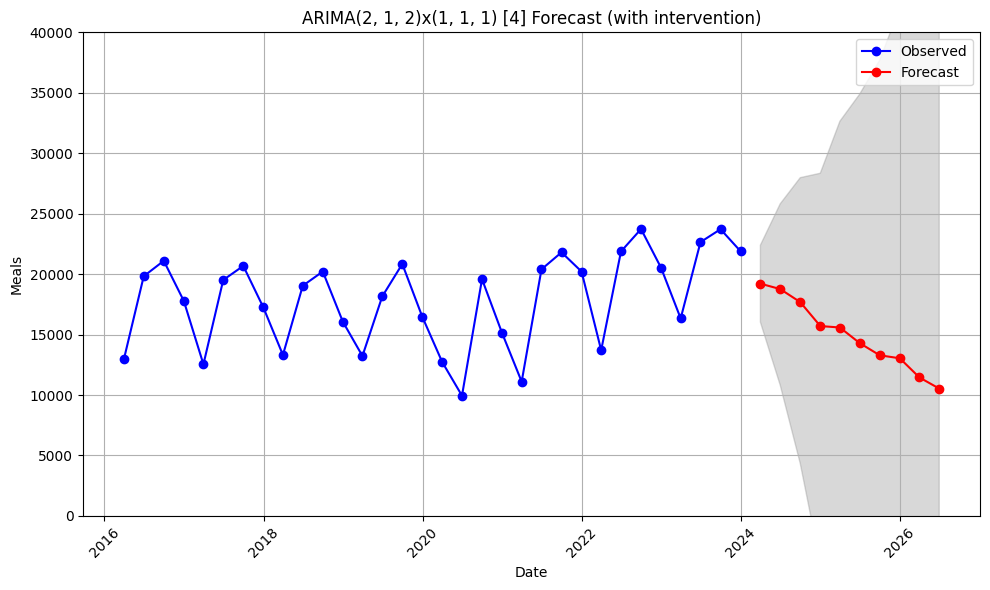

In [27]:
# Plot the original data
plt.figure(figsize=(10, 6))
plt.plot(quarterly_meals[-32:].index, quarterly_meals[-32:], label='Observed', marker='o', linestyle='-', color='b')

# Plot the integrated forecast
plt.plot(pd.date_range(start=quarterly_meals.index[-1], periods=11, freq='QE')[1:], forecast_integrated, label='Forecast', marker='o', linestyle='-', color='r')

# Plot the integrated confidence intervals
plt.fill_between(pd.date_range(start=quarterly_meals.index[-1], periods=len(forecast_diff)+1, freq='QE')[1:], integrated_lower_bound, integrated_upper_bound, color='grey', alpha=0.3)

plt.title('ARIMA(2, 1, 2)x(1, 1, 1) [4] Forecast (with intervention)')
plt.xlabel('Date')
plt.ylabel('Meals')
plt.legend()
plt.ylim(0, 40000) 
plt.xticks(rotation=45)
plt.tight_layout()  
plt.grid(True)
plt.show()

#### Evaluation

In [28]:
# SARIMAX model
model = SARIMAX(train, order=(0,1,2), seasonal_order=(1,1,1,4), exog=intervention[:-12])
results = model.fit(maxiter=1000)
forecast = results.get_forecast(steps=12, exog=[0]*12)
forecast_diff = forecast.predicted_mean

# Reverse the differencing to get the forecast on the original scale
last_value = quarterly_meals.iloc[-1]  # The last value of the original non-differenced data
val_arima = last_value + forecast_diff.cumsum()

# Evaluation (with train/val dataset)
mae = mean_absolute_error(val, val_arima)
print('MAE:', mae)
rmse = np.sqrt(mean_squared_error(val, val_arima))
print('RMSE:', rmse)
mape = mean_absolute_percentage_error(val, val_arima)
print('MAPE:', mape)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73988D+00    |proj g|=  3.43805D-02

At iterate    5    f=  8.72862D+00    |proj g|=  4.02194D-03

At iterate   10    f=  8.72684D+00    |proj g|=  1.89869D-04

At iterate   15    f=  8.72672D+00    |proj g|=  2.06698D-03

At iterate   20    f=  8.70491D+00    |proj g|=  4.99898D-02

At iterate   25    f=  8.29582D+00    |proj g|=  3.04244D-02

At iterate   30    f=  8.29056D+00    |proj g|=  2.75226D-03

At iterate   35    f=  8.29052D+00    |proj g|=  8.76886D-05

At iterate   40    f=  8.29050D+00    |proj g|=  2.23880D-03

At iterate   45    f=  8.28789D+00    |proj g|=  2.50472D-02

At iterate   50    f=  8.20651D+00    |proj g|=  3.72701D-02


 This problem is unconstrained.



At iterate   55    f=  8.16863D+00    |proj g|=  3.11416D-03

At iterate   60    f=  8.16675D+00    |proj g|=  6.39821D-03

At iterate   65    f=  8.16129D+00    |proj g|=  2.22554D-02

At iterate   70    f=  8.15972D+00    |proj g|=  1.18877D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     73     93      1     0     0   5.731D-06   8.160D+00
  F =   8.1597062598967014     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
MAE: 3866.17459818228
RMSE: 4573.49047255581
MAPE: 0.22450930292360358


## Holt-Winters

### With Powell optimization

**Evaluation**

In [29]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Exponential Smoothing
model = ExponentialSmoothing(train, trend='additive', seasonal='additive', seasonal_periods=4, initialization_method='heuristic')
results = model.fit(optimized=True,
                     remove_bias=False,
                     method='Powell'  # works with 'basinhopping' and 'Powell'
                     )

# Forecast the next 10 periods of the differenced data
forecast_diff = results.forecast(12)

# Reverse the differencing to get the forecast on the original scale
last_value = quarterly_meals.iloc[-1]  # The last value of the original non-differenced data
val_powell = last_value + forecast_diff.cumsum()

# Evaluation
mae = mean_absolute_error(val, val_powell)
print('MAE Powell:', mae)
rmse = np.sqrt(mean_squared_error(val, val_powell))
print('RMSE Powell:', rmse)
mape = mean_absolute_percentage_error(val, val_powell)
print('MAPE Powell:', mape)

MAE Powell: 3675.0051582875126
RMSE Powell: 4668.212096026575
MAPE Powell: 0.22163554588406473


**Forecast**

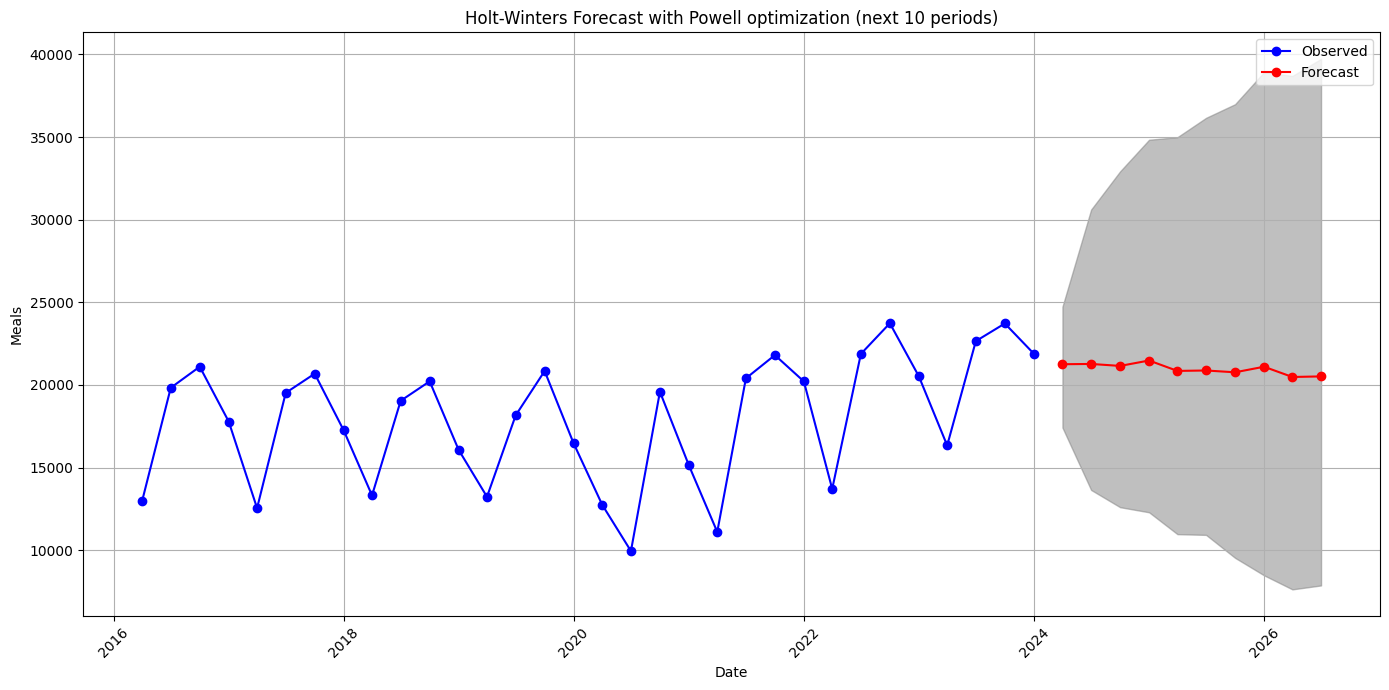

In [30]:
# Fit the Exponential Smoothing model on the differenced data
model = ExponentialSmoothing(diff_quarterly1, 
                             trend='additive', 
                             seasonal='additive', 
                             seasonal_periods=4, 
                             initialization_method='heuristic')
results = model.fit(optimized=True,
                    remove_bias=False,
                    method='Powell')

# Forecast the next 10 periods of the differenced data
forecast_diff = results.forecast(10)

# Reverse the differencing to get the forecast on the original scale
last_value = quarterly_meals.iloc[-1]  # The last value of the original non-differenced data
forecast_integrated = last_value + forecast_diff.cumsum()

# Simulate future residuals by bootstrapping the historical residuals
simulated_residuals = np.random.choice(results.resid, size=(10, 1000))
simulated_paths = np.cumsum(simulated_residuals, axis=0) + last_value

# Calculate the percentiles for each period across all simulated paths
lower_percentiles = np.percentile(simulated_paths, 2.5, axis=1)
upper_percentiles = np.percentile(simulated_paths, 97.5, axis=1)

# Calculate the lower and upper bounds for the forecasted values
lower_bounds = forecast_integrated - (last_value - lower_percentiles)
upper_bounds = forecast_integrated + (upper_percentiles - last_value)

# Plot the original data
plt.figure(figsize=(14, 7))
plt.plot(quarterly_meals[-32:].index, quarterly_meals[-32:], label='Observed', marker='o', linestyle='-', color='b')

# Plot the integrated forecast
plt.plot(pd.date_range(start=quarterly_meals.index[-1], periods=11, freq='QE')[1:], forecast_integrated, label='Forecast', marker='o', linestyle='-', color='r')

# Plot the integrated confidence intervals
plt.fill_between(pd.date_range(start=quarterly_meals.index[-1], periods=11, freq='QE')[1:], lower_bounds, upper_bounds, color='grey', alpha=0.5)

plt.title('Holt-Winters Forecast with Powell optimization (next 10 periods)')
plt.xlabel('Date')
plt.ylabel('Meals')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

### With Basin-Hoppin optimization

**Evaluation**

In [31]:
# Exponential Smoothing
model = ExponentialSmoothing(train, trend='additive', seasonal='additive', seasonal_periods=4, initialization_method='heuristic')
results = model.fit(optimized=True,
                     remove_bias=False,
                     method='basinhopping'  # works with 'basinhopping' and 'Powell'
                     )

# Forecast the next 10 periods of the differenced data
forecast_diff = results.forecast(12)

# Reverse the differencing to get the forecast on the original scale
last_value = quarterly_meals.iloc[-1]  # The last value of the original non-differenced data
val_basinhopping = last_value + forecast_diff.cumsum()

# Evaluation
mae = mean_absolute_error(val, val_basinhopping)
print('MAE Basin-Hoppin:', mae)
rmse = np.sqrt(mean_squared_error(val, val_basinhopping))
print('RMSE Basin-Hoppin:', rmse)
mape = mean_absolute_percentage_error(val, val_basinhopping)
print('MAPE Basin-Hoppin:', mape)

MAE Basin-Hoppin: 3675.6488804836554
RMSE Basin-Hoppin: 4668.942452507789
MAPE Basin-Hoppin: 0.22166354662387744


**Forecast**

In [242]:
diff_quarterly1

Date
2001-06-30     538.000000
2001-09-30   -1118.500000
2001-12-31     985.000000
2002-03-31    -253.000000
2002-06-30    1961.500000
                 ...     
2022-12-31   -1615.000000
2023-03-31    2318.928571
2023-06-30   -1855.428571
2023-09-30    -789.000000
2023-12-31    1381.000000
Freq: QE-DEC, Name: Total, Length: 91, dtype: float64

In [244]:
meals = data['Total']
meals

Date
2000-01-01     93.0
2000-01-02    245.0
2000-01-03     82.0
2000-01-04     97.0
2000-01-05    138.0
              ...  
2023-12-27    194.0
2023-12-28    201.0
2023-12-29    201.0
2023-12-30    233.0
2023-12-31    193.0
Name: Total, Length: 8765, dtype: float64

WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.


WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.




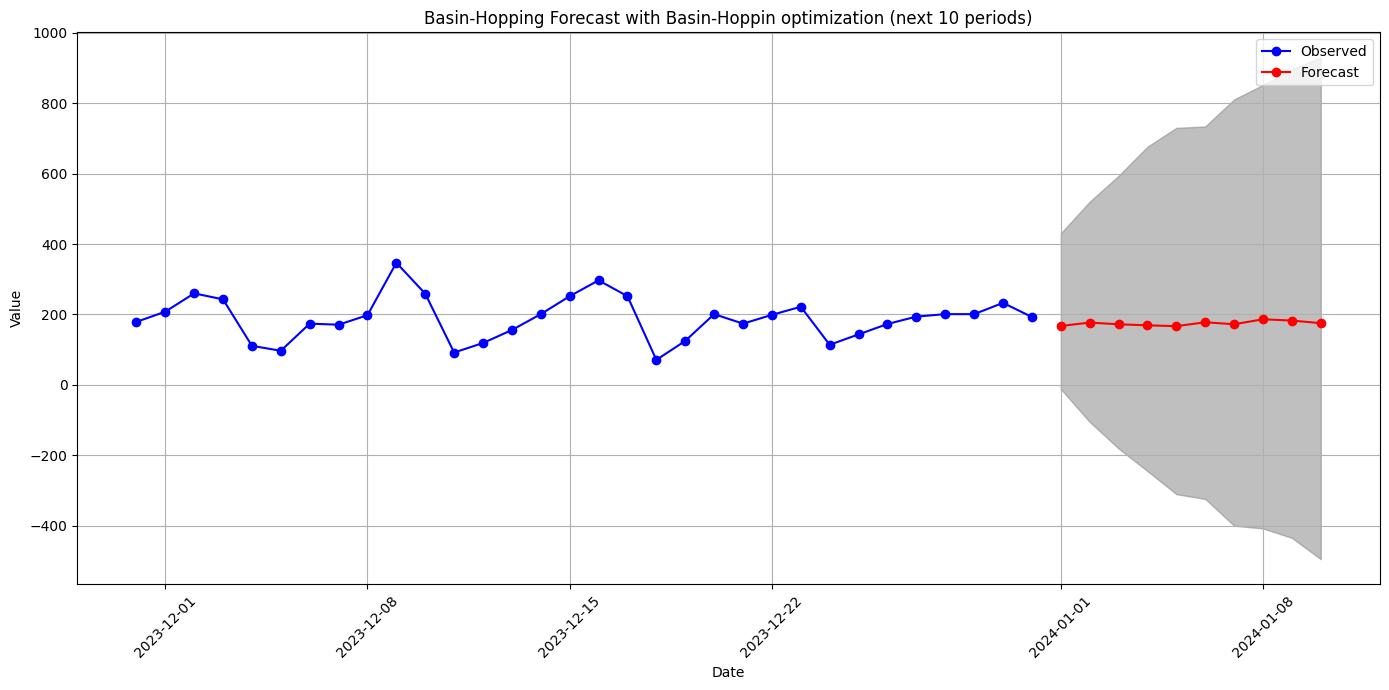

In [249]:
# Fit the Exponential Smoothing model on the differenced data
model = ExponentialSmoothing(meals, 
                             trend='additive', 
                             seasonal='additive', 
                             seasonal_periods=365, 
                             initialization_method='heuristic')
results = model.fit(optimized=True,
                    remove_bias=False,
                    method='basinhopping')

# Forecast the next 10 periods of the differenced data
forecast = results.forecast(10)

# Reverse the differencing to get the forecast on the original scale
#last_value = quarterly_meals.iloc[-1]  # The last value of the original non-differenced data
#forecast_integrated = last_value + forecast_diff.cumsum()

# Simulate future residuals by bootstrapping the historical residuals
simulated_residuals = np.random.choice(results.resid, size=(10, 1000))
simulated_paths = np.cumsum(simulated_residuals, axis=0) + last_value

# Calculate the percentiles for each period across all simulated paths
lower_percentiles = np.percentile(simulated_paths, 2.5, axis=1)
upper_percentiles = np.percentile(simulated_paths, 97.5, axis=1)

# Calculate the lower and upper bounds for the forecasted values
lower_bounds = forecast - (last_value - lower_percentiles)
upper_bounds = forecast + (upper_percentiles - last_value)

# Plot the original data
plt.figure(figsize=(14, 7))
plt.plot(meals[-32:].index, meals[-32:], label='Observed', marker='o', linestyle='-', color='b')

# Plot the integrated forecast
plt.plot(pd.date_range(start=meals.index[-1], periods=11, freq='D')[1:], forecast, label='Forecast', marker='o', linestyle='-', color='r')

# Plot the integrated confidence intervals
plt.fill_between(pd.date_range(start=meals.index[-1], periods=11, freq='D')[1:], lower_bounds, upper_bounds, color='grey', alpha=0.5)

plt.title('Basin-Hopping Forecast with Basin-Hoppin optimization (next 10 periods)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

## NeuralProphet

In [76]:
#Training dataset
train = data['Total'][dt.datetime(2000,1,1,0,0):dt.datetime(2023,10,11,0,0)]
train = pd.DataFrame(train.reset_index()).rename(columns={"Date": "ds", "Total": "y"})

#Validation dataset
val = data['Total'][dt.datetime(2023,10,12,0,0):]
val = pd.DataFrame(val.reset_index()).rename(columns={"Date": "ds", "Total": "y"})

In [238]:
from neuralprophet import NeuralProphet, set_log_level

# Disable logging messages unless there is an error
set_log_level("ERROR")

# Initialize the NeuralProphet model
model = NeuralProphet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False, 
    future_regressors_model='neural_nets',
    seasonality_reg=50,
    n_forecasts=14,
    future_regressors_num_hidden_layers=50,
    #learning_rate=0.5,
    epochs=60,
    batch_size=2000,
    normalize='off',
    loss_func='MAE',
    optimizer='SGD'
)

# Train the model
model.fit(train, freq='D', validation_df=val)

# Create a DataFrame for future dates
future_dates = model.make_future_dataframe(train, periods=81)

# Forecast
forecast = model.predict(future_dates)

# Extract the forecasted values
forecast_values = forecast[["ds", "yhat1"]]

WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lig

Finding best initial lr:   0%|          | 0/248 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralproph

Predicting: 5it [00:00, ?it/s]

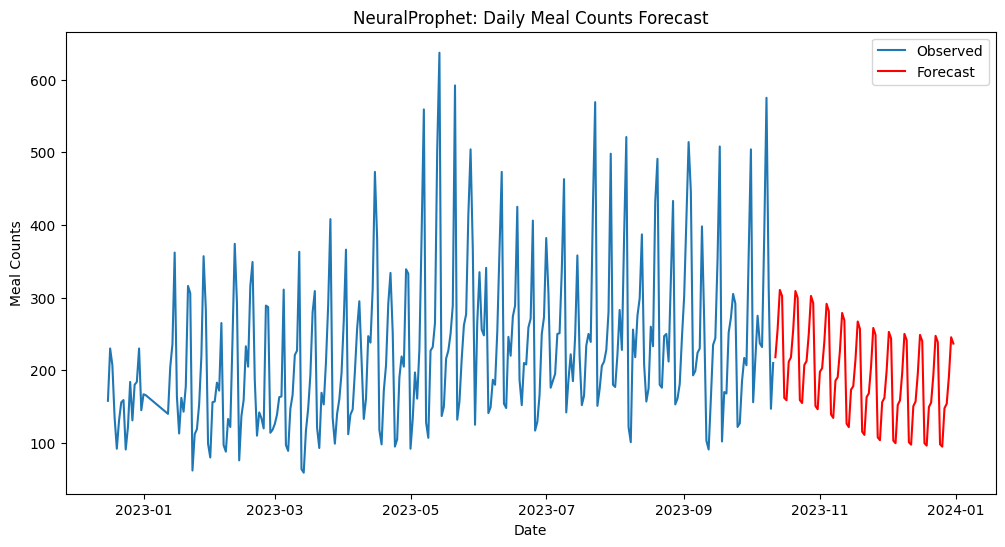

In [239]:
plt.figure(figsize=(12, 6))

# Plot original data
plt.plot(train.iloc[-300:]['ds'], train.iloc[-300:]['y'], label='Observed')

# Plot forecasted values
plt.plot(forecast['ds'], forecast['yhat1'], label='Forecast', color='red')

plt.title('NeuralProphet: Daily Meal Counts Forecast')
plt.xlabel('Date')
plt.ylabel('Meal Counts')
plt.legend()
plt.show()

In [240]:
forecast = forecast_values.set_index('ds')['yhat1']
validation = val.set_index('ds')['y']

In [57]:
from sklearn.metrics import mean_absolute_percentage_error

In [241]:
mean_absolute_percentage_error(validation, forecast)

0.18946417584789696

**MAPE**
*  lr=0.01, epochs=60 --> 0.2183 (val_size=61)
*  lr=0.1, epochs=60 --> 0.3739 (val_size=14)
*  lr=0.5, epochs=60 --> 0.2090 (val_size=14)
*  lr=0.5, epochs=60, batch_size=1000, normalize='off' --> 0.1968 (val_size=61)
*  lr=0.5, epochs=60, batch_size=1000, normalize='minmax' --> 0.2258 (val_size=61)
*  lr=0.5, epochs=60, batch_size=1000, normalize='standardize' --> 0.2232 (val_size=61)
*  lr=1, epochs=60, batch_size=1000, normalize='off' --> 0.2073 (val_size=61)
*  epochs=60, batch_size=2000, normalize='off', optimizer='SGD' --> 0.1909 (val_size=61)
*  epochs=60, batch_size=2000, normalize='off', optimizer='SGD', n_forecasts=28 --> 0.1901
*  epochs=60, batch_size=2000, normalize='off', optimizer='SGD', n_forecasts=28, seasonality_reg=50, future_regressors_num_hidden_layers=14 --> 0.1894